# Solve Variational Problems with FEniCS

For the sake of this problem, we will consider a cable with constant density (length) $\rho$, of length $L$ suspended at the ends from poles of height $P$.  The distance between the poles will be $D$. From the principle of least action, it can be shown that the shape of the cable ($y(x)$) where $y$ is the height and $x$ is the distance along the base from one pole to the other, satisfies the variational problem:

$$
\min_y \int_{-1}^1 y \sqrt{1 + (\epsilon y')^2} \, dx, \quad \text{subject to} \quad 
\int_{-1}^1 \sqrt{1 + (\epsilon y')^2} \, dx = L , \quad \epsilon = \frac{P}{D} \ll 1
$$

Using Lagrange multiplier $\lambda$, the problem may be written as 

$$
\min_{y, \lambda} \int_{-1}^1 (y + \lambda) \sqrt{1 + (\epsilon y')^2} \, dx - \lambda L
$$

The solution is of course a catenary.  But let's see if we can do this numerically using FEniCS to do all the heavy lifting.


In [1]:
from fenics import *
from mshr import *
import matplotlib.pyplot as plt

In [2]:
# problem parameters
eps = 0.6
cable_length = 2.3
pole_height_rat = 2

ϵ = Constant(eps)
L = Constant(cable_length)

# build domain
Nx = 100
a = -1
b = 1
interval_length = b - a
mesh = IntervalMesh(Nx, a, b)

cell = mesh.ufl_cell()

Vy = FiniteElement("CG", cell, 1)

# space for lagrange multiplier
R = FiniteElement("R", cell, 0)

# space for lagrangian
V = FunctionSpace(mesh, MixedElement([Vy, R]))

# build the problem
Λ = Function(V)
y, λ = split(Λ)

# unit cable length
dsdx = sqrt(1 + (ϵ * y.dx(0))**2)

# constraint
constraint = dsdx - L / Constant(interval_length)

# build lagrangian
lagrangian = (y * dsdx - λ * constraint) * dx
dLag = derivative(lagrangian, Λ)

# boundary condition
def bound_left(x, on_boundary):
    return on_boundary and x < 0
def bound_right(x, on_boundary):
    return on_boundary and x > 0

bc_left = DirichletBC(V.sub(0), Constant(1), bound_left)
bc_right = DirichletBC(V.sub(0), Constant(pole_height_rat), bound_right)
bcs = [bc_left, bc_right]

8.881784197001252e-16


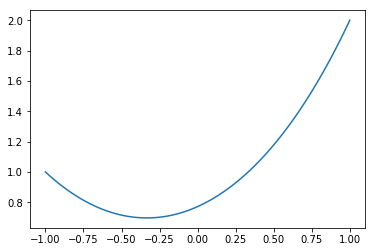

In [3]:
# initial guess
init_amp = 1
Λ.interpolate(Expression(("amp * (x[0] + 0.5 * Lhat) * (x[0] - 0.5 * Lhat)", "0"), 
                         degree=2, Lhat=interval_length, amp=init_amp))

# solver
problem = NonlinearVariationalProblem(dLag, Λ, bcs, derivative(dLag, Λ))

solver = NonlinearVariationalSolver(problem)
prm = solver.parameters
prm["nonlinear_solver"] = "snes"
prm["snes_solver"]["line_search"] = "bt"
prm["snes_solver"]["maximum_iterations"] = 1000

# solve the problem
solver.solve()

# sanity check, expect zero
print(assemble(dsdx * dx) - float(L))

# plot results
plot(y)
plt.show()